### Import necessary dependencies

In [1]:
import os
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms.functional as TF
from torchvision.transforms.functional import to_pil_image
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import random
from torchvision.transforms import ToPILImage

torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Defining modcrop function
- Make sure the image's width and height is completely divisible by the scale that we want to downsample the image to.

In [2]:
def modcrop(img, scale):
    h, w = img.shape[1], img.shape[2]  # img = torch.Size([3, H, W])
    h = h - (h % scale)
    w = w - (w % scale)
    img = img[:, :h, :w]
    return img

### Define preprocessing function and function to display the GT and LR version of an image
- Downsample each images in a folder and return a tuple containing the GT and input image

In [130]:
def image_to_patches(image, patch_size):
    channels, height, width = image.size()
    patch_channels, patch_height, patch_width = patch_size
    patches = []

    # Pad the image to ensure its dimensions are divisible by the patch size
    pad_height = patch_height - height % patch_height
    pad_width = patch_width - width % patch_width
    padded_image = F.pad(image, (0, pad_width, 0, pad_height), mode='constant', value=0)

    # Extract patches from the padded image
    for y in range(0, height, patch_height):
        for x in range(0, width, patch_width):
            patch = padded_image[:, y:y+patch_height, x:x+patch_width]
            patches.append(patch)

    return patches

In [131]:
def preprocess_images_in_folder(folder_path, scale, patch_size):
    processed_images = []

    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        input_image = Image.open(img_path).convert('RGB')

        # Convert input image to tensor
        GT_tensor = TF.to_tensor(input_image).float()

        # Interpolate GT image to create LR image
        LR_image = TF.resize(input_image, [input_image.size[0] // scale, input_image.size[1] // scale], interpolation=Image.BICUBIC)
        LR_tensor = TF.to_tensor(LR_image).float()

        # Resize LR image to match the size of GT image
        LR_image = TF.resize(LR_image, [GT_tensor.shape[1], GT_tensor.shape[2]], interpolation=Image.BICUBIC)
        LR_tensor = TF.to_tensor(LR_image).float()

        # Divide LR and GT images into patches
        LR_patches = image_to_patches(LR_tensor, patch_size)
        GT_patches = image_to_patches(GT_tensor, patch_size)

        # Append LR and GT patches as a tuple
        processed_images.extend(zip(LR_patches, GT_patches))

    return processed_images

In [132]:
def display_image(LR, GT):
    
    # Display the label image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(GT.permute(1, 2, 0))
    plt.title('Ground Truth (GT)')
    plt.axis('off')
    
    # Display the input image
    plt.subplot(1, 2, 2)
    plt.imshow(LR.permute(1, 2, 0))
    plt.title('Low Resolution (LR)')
    plt.axis('off')

    plt.show()

### Preprocessing training images

In [133]:

train_folder_path = 'data/Train/'
test_set5_folder_path = 'data/Test/Set5/'
test_set14_folder_path = 'data/Test/Set14/'
scale = 3

processed_train_images = preprocess_images_in_folder(train_folder_path, scale, (3, 33,33))
processed_test_set5_images = preprocess_images_in_folder(test_set5_folder_path, scale, (3, 33,33))
processed_test_set14_images = preprocess_images_in_folder(test_set14_folder_path, scale, (3, 33, 33))

### Display random test images from Set5

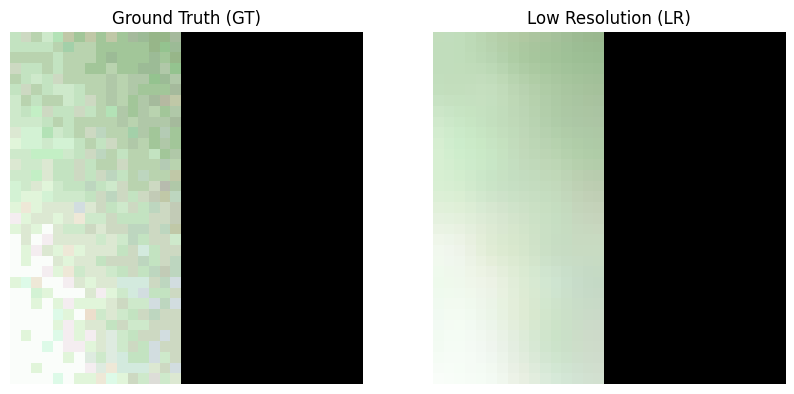

In [151]:
# Select a random image from the preprocessed images
random_image = random.choice(processed_test_set5_images)
LR, GT = random_image

# Display the random image
display_image(LR, GT)

### Putting preprocessed images in DataLoader

In [152]:
train_loader = DataLoader(processed_train_images, batch_size=128)
test_set5_loader = DataLoader(processed_test_set5_images, batch_size=128)
test_set14_loader = DataLoader(processed_test_set14_images, batch_size=128)

### Define SRCNN model architecture

In [153]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=4)
        self.relu1 = nn.ReLU(True)
        
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU(True)
        
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, stride=1, padding=2)
        
    def forward(self, x):
        out = self.relu1(self.conv1(x))
        out = self.relu2(self.conv2(out))
        out = self.conv3(out)
        return out

### Settting up hyperparameters

In [192]:
model = SRCNN()
criterion = nn.SmoothL1Loss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
num_epochs = 50

### Training loop

In [193]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for LR, GT in train_loader:
        LR, GT = LR.to(device), GT.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(LR)
        
        # Compute loss
        loss = criterion(outputs, GT)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * LR.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}')

print('Training finished.')

torch.save(model.state_dict(), 'srcnn_model.pth')

Epoch [1/50], Loss: 0.050014380485522904
Epoch [2/50], Loss: 0.018765775749302643
Epoch [3/50], Loss: 0.016964703134776698
Epoch [4/50], Loss: 0.01554501989192845
Epoch [5/50], Loss: 0.014238608522721711
Epoch [6/50], Loss: 0.013085613582810875
Epoch [7/50], Loss: 0.012119835716950706
Epoch [8/50], Loss: 0.01133963107817589
Epoch [9/50], Loss: 0.010707919614440169
Epoch [10/50], Loss: 0.010177565268234207
Epoch [11/50], Loss: 0.009712481285673227
Epoch [12/50], Loss: 0.00929147440231324
Epoch [13/50], Loss: 0.008903642637370012
Epoch [14/50], Loss: 0.008544475903390815
Epoch [15/50], Loss: 0.008212134796321307
Epoch [16/50], Loss: 0.007905044812090875
Epoch [17/50], Loss: 0.0076216577135228974
Epoch [18/50], Loss: 0.007360362061412635
Epoch [19/50], Loss: 0.00711955680966228
Epoch [20/50], Loss: 0.006897748517237593
Epoch [21/50], Loss: 0.006693578942096626
Epoch [22/50], Loss: 0.006505578779648771
Epoch [23/50], Loss: 0.00633221394242519
Epoch [24/50], Loss: 0.006172044064785662
Epoch

### Test using validation sets

In [194]:
# Evaluate model on validation set 5
model.eval()
val_loss = 0.0

with torch.no_grad():
    for batch_idx, (val_inputs, val_labels) in enumerate(test_set5_loader):
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        
        val_outputs = model(val_inputs)
        
        val_loss += criterion(val_outputs, val_labels).item()
    
    # Calculate average validation loss
    average_val_loss = val_loss / len(test_set5_loader)
    print(f"Validation Loss for Set 5: {average_val_loss}")

Validation Loss for Set 5: 0.002857793588191271


In [195]:
# Evaluate model on validation set 14
model.eval()
val_loss = 0.0

with torch.no_grad():
    for batch_idx, (val_inputs, val_labels) in enumerate(test_set14_loader):
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        
        val_outputs = model(val_inputs)
        
        val_loss += criterion(val_outputs, val_labels).item()
    
    # Calculate average validation loss
    average_val_loss = val_loss / len(test_set14_loader)
    print(f"Validation Loss for Set 14: {average_val_loss}")

Validation Loss for Set 14: 0.004135876358486712


### Visualizing result

In [196]:
# Load the single input image
input_image_path = 'woman_GT.bmp'  # Replace 'input_image.png' with your image path
input_image = Image.open(input_image_path).convert('RGB')

# Convert the image to tensor
input_tensor = TF.to_tensor(input_image).float()  # Change to float

# Assuming scale factor is 3 (adjust if different)
scale = 3

# Process image for GT (ground truth) and LR (low resolution)
GT_image = input_tensor
LR_image = TF.resize(GT_image, [GT_image.shape[1] // scale, GT_image.shape[2] // scale], interpolation=Image.BICUBIC)
LR_image = TF.resize(LR_image, [GT_image.shape[1], GT_image.shape[2]], interpolation=Image.BICUBIC)

# Convert LR image to tensor and add batch dimension
LR_tensor = LR_image.unsqueeze(0)

# Move tensor to device (assuming model is trained on GPU)
LR_tensor = LR_tensor.to(device)

# Perform inference
model.eval()
with torch.no_grad():
    SR_tensor = model(LR_tensor)

# Convert SR tensor back to PIL image
SR_image = TF.to_pil_image(SR_tensor.squeeze(0).cpu())

# Save the super-resolved image
output_image_path = 'woman_HR.bmp'
SR_image.save(output_image_path)  # Save the image as 'super_resolved_image.png' or any desired filename


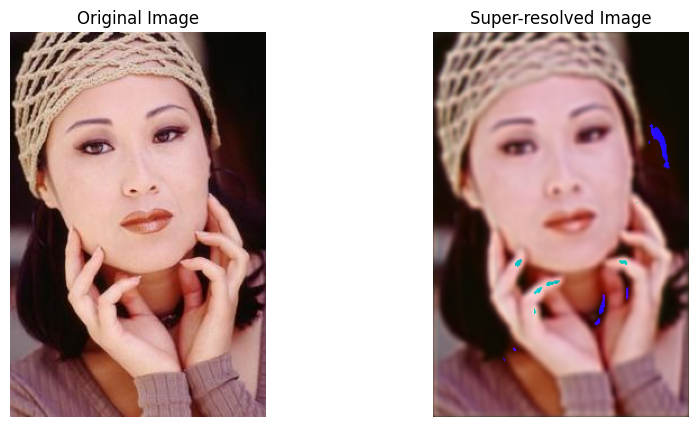

In [197]:
# Load the original and super-resolved images
original_image = Image.open(input_image_path).convert('RGB')  # Load original image
super_resolved_image = Image.open(output_image_path).convert('RGB')  # Load super-resolved image

# Display the images side by side using matplotlib
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

# Super-resolved image
plt.subplot(1, 2, 2)
plt.imshow(super_resolved_image)
plt.title('Super-resolved Image')
plt.axis('off')

plt.show()
